In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

model = SentenceTransformer('all-MiniLM-L6-v2')

data = [
    {"name": "Boho Dress", "desc": "Flowy dress with earthy tones and boho vibes", "colors": ["brown", "tan"], "vibes": ["boho", "relaxed"]},
    {"name": "Urban Jacket", "desc": "Trendy jacket for energetic urban street look", "colors": ["black", "red"], "vibes": ["urban", "energetic"]},
    {"name": "Cozy Sweater", "desc": "Soft warm sweater for cozy winter day", "colors": ["cream", "brown"], "vibes": ["cozy", "warm"]},
    {"name": "Sporty Shoes", "desc": "Comfortable shoes for active sporty lifestyle", "colors": ["white", "blue"], "vibes": ["sporty", "active"]},
    {"name": "Minimal Tote", "desc": "Simple clean tote bag for daily use", "colors": ["white", "black"], "vibes": ["minimal", "modern"]},
    {"name": "Vintage Scarf", "desc": "Retro patterned scarf with classic elegance", "colors": ["burgundy", "gold"], "vibes": ["vintage", "elegant"]},
    {"name": "Athleisure Leggings", "desc": "Stretchy leggings for workout or casual wear", "colors": ["black", "purple"], "vibes": ["athletic", "casual"]},
    {"name": "Chic Blazer", "desc": "Tailored blazer for professional office looks", "colors": ["navy", "beige"], "vibes": ["professional", "chic"]},
    {"name": "Festival Top", "desc": "Colorful crop top with bohemian patterns", "colors": ["orange", "pink"], "vibes": ["festival", "boho"]},
    {"name": "Luxury Watch", "desc": "Elegant watch with minimalist design", "colors": ["gold", "black"], "vibes": ["luxury", "elegant"]}
]

df = pd.DataFrame(data)


In [ ]:
def make_combined_text(row):
    return f"{row['desc']} Colors: {', '.join(row['colors'])} Vibes: {', '.join(row['vibes'])}"

df['combined_text'] = df.apply(make_combined_text, axis=1)

start = time.time()
embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=False)
df["embedding"] = list(embeddings)

def find_matches(query, top_k=3):
    q_emb = model.encode([query])[0].reshape(1, -1)
    product_embs = np.vstack(df["embedding"].values)
    scores = cosine_similarity(q_emb, product_embs)[0]
    top_idx = scores.argsort()[::-1][:top_k]
    return top_idx, scores[top_idx]

test_queries = [
    "energetic urban chic",
    "cozy warm winter",
    "elegant professional"
]

products : ['Urban Jacket', 'Festival Top', 'Chic Blazer']
products : ['Cozy Sweater', 'Urban Jacket', 'Vintage Scarf']
products : ['Chic Blazer', 'Luxury Watch', 'Vintage Scarf']


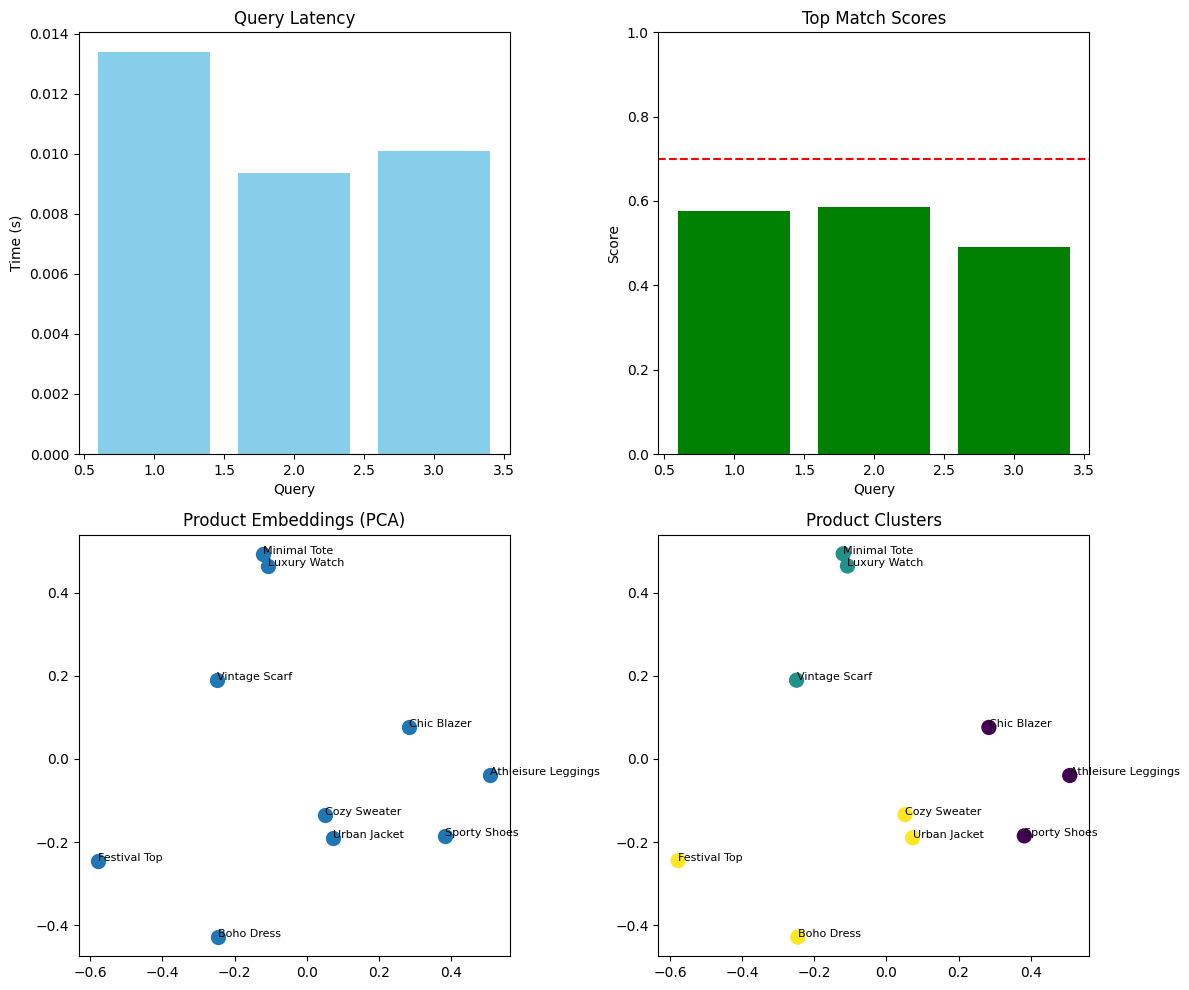

In [ ]:
results = []
latencies = []

for query in test_queries:
    start = time.time()
    indices, scores = find_matches(query)
    # print(indices,scores)
    latency = time.time() - start
    latencies.append(latency)
    print("products :" ,[df.iloc[i]['name'] for i in indices])
    results.append({"query": query, "top_score": scores[0], "latency": latency})

metrics = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].bar(range(1, 4), latencies, color='skyblue')
axes[0, 0].set_title('Query Latency')
axes[0, 0].set_xlabel('Query')
axes[0, 0].set_ylabel('Time (s)')

axes[0, 1].bar(range(1, 4), metrics['top_score'], color='green')
axes[0, 1].axhline(y=0.7, color='red', linestyle='--')
axes[0, 1].set_title('Top Match Scores')
axes[0, 1].set_xlabel('Query')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1])

product_embs = np.vstack(df["embedding"].values)
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(product_embs)

axes[1, 0].scatter(emb_2d[:, 0], emb_2d[:, 1], s=100)
for i, name in enumerate(df['name']):
    axes[1, 0].text(emb_2d[i, 0], emb_2d[i, 1], name, fontsize=8)
axes[1, 0].set_title('Product Embeddings (PCA)')

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(product_embs)
axes[1, 1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=clusters, cmap='viridis', s=100)
for i, name in enumerate(df['name']):
    axes[1, 1].text(emb_2d[i, 0], emb_2d[i, 1], name, fontsize=8)
axes[1, 1].set_title('Product Clusters')

plt.tight_layout()
plt.savefig('vibe_matcher_results.png', dpi=300)
plt.show()